<a href="https://colab.research.google.com/github/sivat14/Assignment_1_DL/blob/main/Assignment_2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q torch sentence-transformers bertopic gensim scikit-learn umap-learn hdbscan wordcloud


In [4]:
# 1) Imports & config

import os
import multiprocessing
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# BERTopic & embedding
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

# dimensionality reduction & clustering
import umap
import hdbscan

# coherence
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# wordcloud
from wordcloud import WordCloud

# device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [5]:
# 2) Load 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))
documents = newsgroups.data
target = newsgroups.target
target_names = newsgroups.target_names

print("Num documents:", len(documents))
print("Num classes (labels):", len(target_names))


Num documents: 18846
Num classes (labels): 20


In [6]:
# 3) Lightweight preprocessing
import re
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    # remove weird quotes and long lines
    text = re.sub(r'http\S+', '', text)
    text = text.strip()
    return text

docs_clean = [clean_text(d) for d in documents]

min_len = 20
filtered_idx = [i for i,d in enumerate(docs_clean) if len(d) >= min_len]
docs_clean = [docs_clean[i] for i in filtered_idx]
target = [target[i] for i in filtered_idx]

print("After filtering short docs:", len(docs_clean))


After filtering short docs: 18221


In [8]:
# 4) Bertopic model

umap_model = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       calculate_probabilities=True,
                       verbose=True,
                       n_gram_range=(1,2),
                       min_topic_size=20)

# Fit on documents
topics, probs = topic_model.fit_transform(docs_clean)

print("Number of topics found:", len(set(topics)) - (1 if -1 in topics else 0))


2025-11-22 14:09:07,840 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/570 [00:00<?, ?it/s]

2025-11-22 14:09:54,616 - BERTopic - Embedding - Completed ✓
2025-11-22 14:09:54,617 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-22 14:10:40,671 - BERTopic - Dimensionality - Completed ✓
2025-11-22 14:10:40,672 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-22 14:10:56,368 - BERTopic - Cluster - Completed ✓
2025-11-22 14:10:56,383 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-22 14:11:08,563 - BERTopic - Representation - Completed ✓


Number of topics found: 121


In [9]:
# 5) Inspect top topics
top_n = 10
topics_info = topic_model.get_topic_info()
pprint(topics_info.head(20))

# Get top words per topic (for coherence)
topic_words = []
n_top_words = 15
for topic_id in topics_info.Topic[topics_info.Topic != -1].tolist():
    words_probs = topic_model.get_topic(topic_id)  # list of (word, score)
    words = [w for w, _ in words_probs][:n_top_words]
    topic_words.append(words)


    Topic  Count                             Name  \
0      -1   7346                  -1_the_to_of_is   
1       0    738               0_team_game_25_the   
2       1    705               1_he_year_the_game   
3       2    693               2_space_the_of_and   
4       3    585           3_key_clipper_chip_the   
5       4    448        4_israel_israeli_jews_the   
6       5    420         5_card_monitor_video_vga   
7       6    405              6_fbi_the_batf_they   
8       7    340                7_gun_of_the_guns   
9       8    286            8_car_cars_engine_the   
10      9    252              9_edu_com_health_of   
11     10    231              10_bike_you_my_ride   
12     11    173          11_amp_audio_for_asking   
13     12    172             12_you_jim_that_your   
14     13    161       13_image_file_files_format   
15     14    156            14_gay_men_sex_sexual   
16     15    151       15_bike_tires_the_the bike   
17     16    143              16_espn_game_pts

In [15]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm.auto import tqdm
import math

SAMPLE_MAX_DOCS = 5000
TOP_N_WORDS = 10
COHERENCE_MEASURE = "c_v"
N_PROCESSES = max(1, min(8, cpu_count()-1))

if SAMPLE_MAX_DOCS is not None and len(docs_clean) > SAMPLE_MAX_DOCS:
    rng = np.random.default_rng(seed=42)
    idx = rng.choice(len(docs_clean), size=SAMPLE_MAX_DOCS, replace=False)
    sampled_docs = [docs_clean[i] for i in idx]
else:
    sampled_docs = docs_clean

texts_tokenized = [simple_preprocess(doc, deacc=True) for doc in sampled_docs]

dictionary = Dictionary(texts_tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.5)

topic_words_trim = [t[:TOP_N_WORDS] for t in topic_words]

coh_model_all = CoherenceModel(topics=topic_words_trim, texts=texts_tokenized,
                               dictionary=dictionary, coherence=COHERENCE_MEASURE, processes=N_PROCESSES)
coherence_c_v = coh_model_all.get_coherence()
print(f"Overall {COHERENCE_MEASURE} coherence (avg over topics): {coherence_c_v:.4f}")

def _coherence_for_topic(topic_terms, texts, dictionary, coherence_measure):
    cm = CoherenceModel(topics=[topic_terms], texts=texts, dictionary=dictionary,
                        coherence=coherence_measure)
    return cm.get_coherence()

with Pool(processes=N_PROCESSES) as pool:
    func = partial(_coherence_for_topic, texts=texts_tokenized, dictionary=dictionary, coherence_measure=COHERENCE_MEASURE)
    per_topic_coh = list(tqdm(pool.imap(func, topic_words_trim), total=len(topic_words_trim), desc="Per-topic coherence"))

valid_topics_info = topics_info[topics_info.Topic != -1].copy().reset_index(drop=True)
n_assign = min(len(valid_topics_info), len(per_topic_coh))
valid_topics_info = valid_topics_info.iloc[:n_assign].copy()
valid_topics_info['coherence_' + COHERENCE_MEASURE] = per_topic_coh[:n_assign]

print("Top 10 topics by coherence:")
print(valid_topics_info.sort_values("coherence_" + COHERENCE_MEASURE, ascending=False).head(10))


Overall c_v coherence (avg over topics): 0.6442


Per-topic coherence:   0%|          | 0/121 [00:00<?, ?it/s]

Top 10 topics by coherence:
    Topic  Count                                 Name  \
90     90     25               90_ax_ax ax_max_max ax   
27     27     96     27_armenian_turkish_armenians_of   
34     34     71         34_islam_rushdie_islamic_qur   
61     61     41    61_greek_greece_turkish_the greek   
17     17    138          17_printer_print_hp_deskjet   
8       8    286                8_car_cars_engine_the   
66     66     37    66_drugs_drug_the drug_drug users   
35     35     69             35_simms_simm_ram_memory   
78     78     31  78_jehovah_elohim_lord_lord jehovah   
37     37     69      37_lib_ndet_loop_libxmu_lib xmu   

                                       Representation  \
90  [ax, ax ax, max, max ax, ax max, g9v, b8f, a86...   
27  [armenian, turkish, armenians, of, the, genoci...   
34  [islam, rushdie, islamic, qur, qur an, of, the...   
61  [greek, greece, turkish, the greek, greeks, in...   
17  [printer, print, hp, deskjet, laser, ink, prin...   
8 

In [17]:
# 7) Topic interpretability metrics
def topic_diversity(topics_list, top_k=10):
    top_k_words = [t[:top_k] for t in topics_list]
    unique_words = set([w for t in top_k_words for w in t])
    return len(unique_words) / (len(top_k_words) * top_k)

def avg_top_overlap(topics_list, top_k=10):
    top_k_words = [set(t[:top_k]) for t in topics_list]
    n = len(top_k_words)
    from itertools import combinations
    overlaps = []
    for a,b in combinations(top_k_words, 2):
        overlaps.append(len(a & b) / top_k)
    return float(np.mean(overlaps))

td = topic_diversity(topic_words, top_k=10)
avg_ov = avg_top_overlap(topic_words, top_k=10)
print(f"Topic Diversity (top-10): {td:.4f}")
print(f"Average top-10 word overlap between topics: {avg_ov:.4f}")


Topic Diversity (top-10): 0.7223
Average top-10 word overlap between topics: 0.0272


In [18]:
# 8) Visualizations
try:
    viz_topics = topic_model.visualize_topics()        # interactive: open in notebook
    viz_barchart = topic_model.visualize_barchart(top_n_topics=10)
    viz_hierarchy = topic_model.visualize_hierarchy()
    # In notebooks these will render automatically. To save, use .to_html(...)
    topic_model.visualize_topics().write_html("bertopic_topics.html")
    topic_model.visualize_barchart(top_n_topics=10).write_html("bertopic_barchart.html")
    topic_model.visualize_hierarchy().write_html("bertopic_hierarchy.html")
    print("Saved bertopic HTML visualizations: bertopic_topics.html, bertopic_barchart.html, bertopic_hierarchy.html")
except Exception as e:
    print("Could not create interactive visualizations in this environment:", e)

# WordClouds: generate for top 8 topics
os.makedirs("topic_wordclouds", exist_ok=True)
for tid in valid_topics_info.Topic.head(2).tolist():
    words = dict(topic_model.get_topic(tid))
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words)
    out_path = f"topic_wordclouds/topic_{tid}.png"
    wc.to_file(out_path)
    print("Saved", out_path)


Saved bertopic HTML visualizations: bertopic_topics.html, bertopic_barchart.html, bertopic_hierarchy.html
Saved topic_wordclouds/topic_0.png
Saved topic_wordclouds/topic_1.png


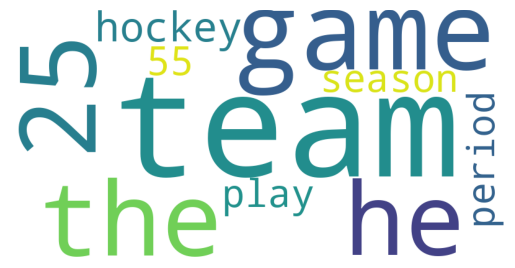

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/topic_wordclouds/topic_0.png")
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

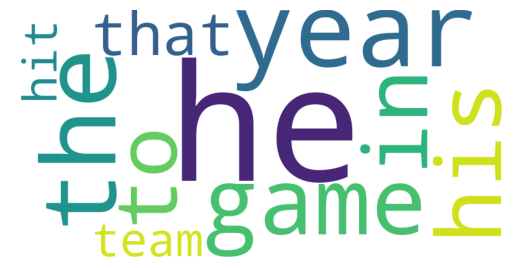

In [21]:

img = mpimg.imread("/content/topic_wordclouds/topic_1.png")
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()